In [9]:
from packaging import version

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorboard as tb

In [33]:
from stable_baselines3 import PPO, A2C
import numpy as np
from finrl.meta.env_pricing.env_pkg_pricing_v2 import DynamicPricingEnv
from gym import spaces
from stable_baselines3 import PPO
from sklearn.model_selection import train_test_split
import pickle

In [152]:
test_raw = pd.read_csv('x_test.csv')
test = test_raw[ (test_raw['rateplan_type']=='Package') & (test_raw['base_price']<= test_raw['ref_price'])
               ].sample(8000, random_state=24)

In [26]:
test_all = test_raw[(test_raw['rateplan_type']=='Package') & (test_raw['base_price']<= test_raw['ref_price'])]
test_eval = test_all[~test_all.index.isin(test.index.tolist())][['base_price'
                                                 , 'base_cost'
                                                 , 'ref_price'
                                                 , 'margin%'
                                                 , 'ab_test_bucket'
                                                 , 'dow'
                                                 , 'checkin_month'
                                                , 'total_adjustment'
                                                 , 'is_booked'
                                                ]]
len(test_eval)

1972

In [29]:
# load the model from disk
filename = 'classification_model/rf_model_simple.sav'
rf_model = pickle.load(open(filename, 'rb'))

In [35]:
INDICATORS = ['base_price', 'base_cost', 'ref_price', 'margin_perc', 'ab_test_bucket', 'dow','checkin_month']
state_space = len(INDICATORS)
print(state_space)

7


In [36]:
test_eval2 = test_eval[['base_price', 'base_cost', 'ref_price', 'margin%', 'ab_test_bucket', 'dow','checkin_month']].reset_index(drop=True)
 
env_kwargs = {"state_space": state_space}
env = DynamicPricingEnv(df = test_eval2, booking_model = rf_model, **env_kwargs)

In [97]:
models_dir = 'tensorboard_df'
model_ppo_best = 'PPO_12'
model_a2c_best = 'A2C_12'

In [119]:
path = f'{models_dir}/run-{model_ppo_best}-tag-rollout_ep_rew_mean.csv'
path_a2c = f'{models_dir}/run-{model_a2c_best}-tag-rollout_ep_rew_mean.csv'
ppo_best_df = pd.read_csv(path)
ppo_best_df['model'] = 'PPO'

a2c_best_df = pd.read_csv(path_a2c)
a2c_best_df['model'] = 'A2C'

In [120]:
best_df = pd.concat([ppo_best_df, a2c_best_df])

In [122]:
l_df_ppo = pd.read_csv('ppo_12_eval_final_1692652963.csv')
l_df_a2c = pd.read_csv('a2c_12_eval_final_1693088278.csv')

l_df_a2c['model'] = 'A2C'
l_df_ppo['model'] = 'PPO'

l_df_comb = pd.concat([l_df_a2c, l_df_ppo])
l_df_comb = l_df_comb.rename(columns={"reward": "reward normalised"})

<AxesSubplot:xlabel='Step', ylabel='reward normalised'>

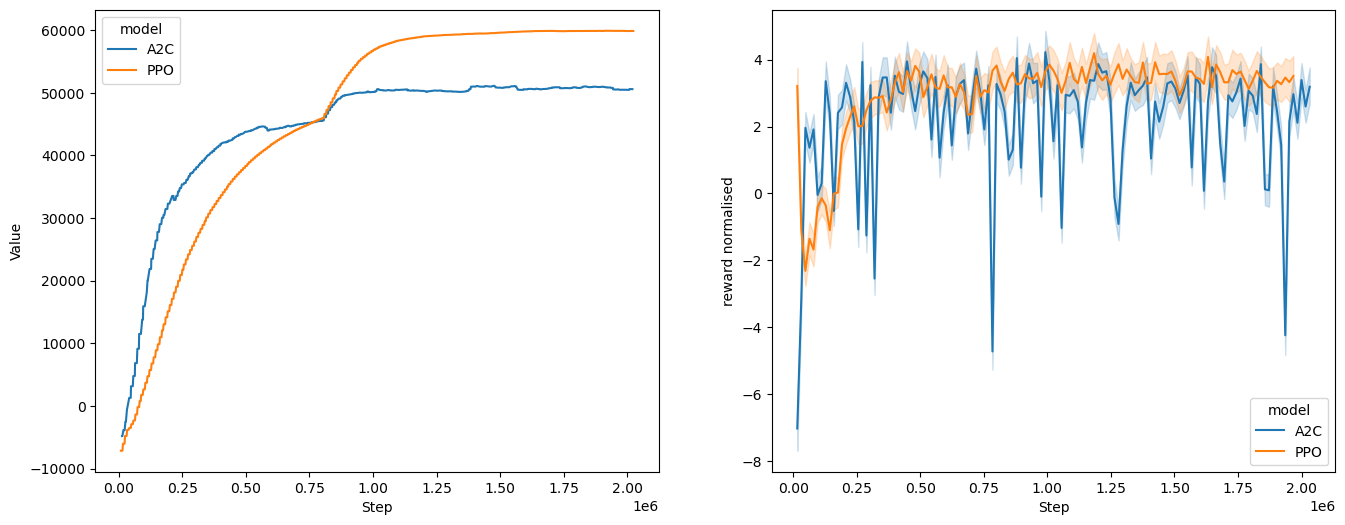

In [132]:
# plot final 2 mehtods average reward per episode
%matplotlib inline

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=best_df, x="Step", y="Value",
             hue='model', hue_order=['A2C', 'PPO'])
# .set_title("Episode Average Reward")
plt.subplot(1, 2, 2)
sns.lineplot(data=l_df_comb, x="Step", y="reward normalised",
             hue='model')
# .set_title("Episode Reward on Validation Dataset")

<AxesSubplot:xlabel='Step', ylabel='Value'>

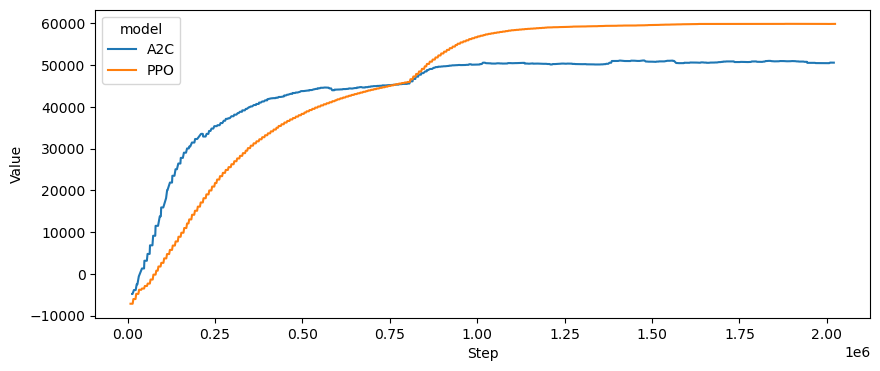

In [136]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=best_df, x="Step", y="Value",
             hue='model', hue_order=['A2C', 'PPO'])

<AxesSubplot:xlabel='Step', ylabel='reward normalised'>

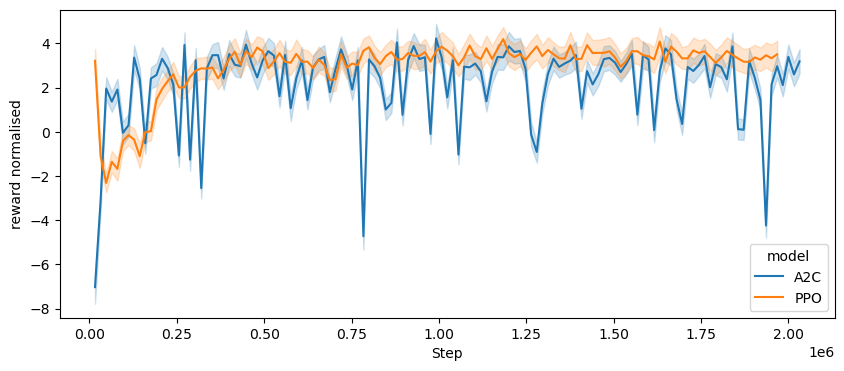

In [139]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=l_df_comb, x="Step", y="reward normalised",
             hue='model')

A2C: hyper parameter tuning
A2C8    lr 0.0003
A2C11    lr 0.0007, decay 0.001, step 5
A2C12   lr 0.0007, decay 0.001, step 10

In [150]:
models_dir = 'tensorboard_df'
model_list = ['A2C_8', 'A2C_11', 'A2C_12']
hp_list = ['A2C lr=0.0003 weight_decay=0 step=5', 'A2C lr=0.0007 weight_decay=0.001 step=5', 'A2C lr=0.0007 weight_decay=0.001 step=10']
a2c_df = pd.DataFrame(columns=['Wall time', 'Step', 'Value', 'model'])

for i, p in zip(model_list, hp_list):
    path_a2c = f'{models_dir}/run-{i}-tag-rollout_ep_rew_mean.csv'
    a2c_df_tmp = pd.read_csv(path_a2c)
    a2c_df_tmp['model'] = p
    a2c_df = pd.concat([a2c_df, a2c_df_tmp])

<AxesSubplot:xlabel='Step', ylabel='Value'>

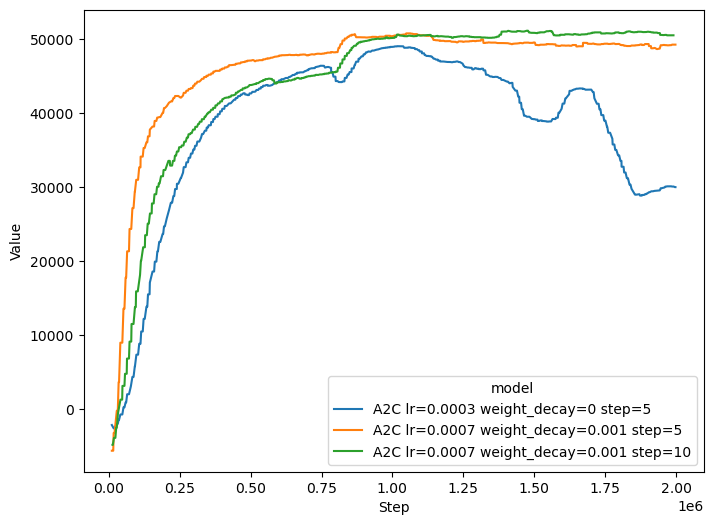

In [151]:
%matplotlib inline
plt.figure(figsize=(8, 6))
sns.lineplot(data=a2c_df[a2c_df['Step']<=2000000], x="Step", y="Value",
             hue='model')
# .set_title("Episode Average Reward")

In [133]:
models_dir = 'tensorboard_df'
model_list = ['PPO_12', 'PPO_15', 'PPO_17', 'PPOv2_PPO_2', 'PPOv2_PPO_5']
hp_list = ['PPO lr=0.0003 target_kl=1 batch_size=64'
           , 'PPO lr=0.0005 target_kl=1 batch_size=128'
           , 'PPO lr=0.0006 target_kl=0 batch_size=128'
           , 'PPO lr=0.0003 target_kl=1 batch_size=32'
           , 'PPO lr=0.00015 target_kl=0.05 batch_size=32'
          ]
ppo_df = pd.DataFrame(columns=['Wall time', 'Step', 'Value', 'model'])

for i, p in zip(model_list, hp_list):
    path_ppo = f'{models_dir}/run-{i}-tag-rollout_ep_rew_mean.csv'

    ppo_df_tmp = pd.read_csv(path_ppo)
    ppo_df_tmp['model'] = p
    ppo_df = pd.concat([ppo_df, ppo_df_tmp])

<AxesSubplot:xlabel='Step', ylabel='Value'>

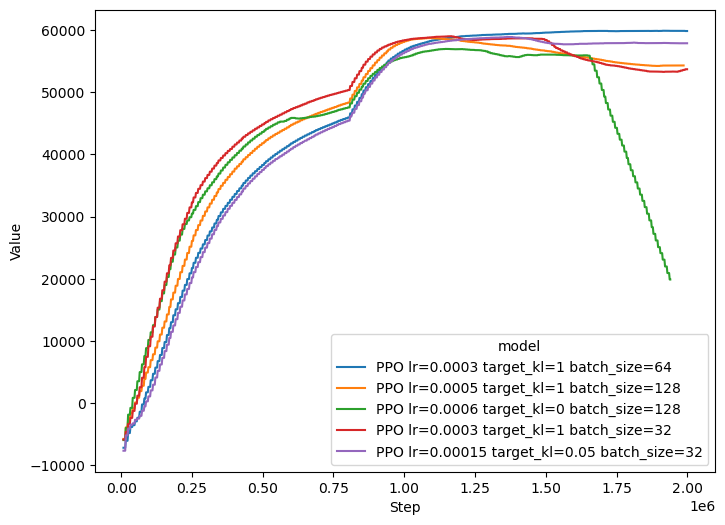

In [134]:
%matplotlib inline
plt.figure(figsize=(8, 6))
# plt.subplot(1, 2, 1)
sns.lineplot(data=ppo_df[ppo_df['Step']<=2000000], x="Step", y="Value",
             hue='model')
# .set_title("Episode Average Reward")

In [145]:
# kl divergence
models_dir = 'tensorboard_df'
model_list = ['PPO_12', 'PPO_15', 'PPO_17']
hp_list = ['PPO lr=0.0003 target_kl=1 batch_size=64'
           , 'PPO lr=0.0005 target_kl=1 batch_size=128'
           , 'PPO lr=0.0006 target_kl=0 batch_size=128'
          ]

ppo_df = pd.DataFrame(columns=['Wall time', 'Step', 'Value', 'model', 'Value_log'])
for i, p in zip(model_list, hp_list):
    path_ppo = f'{models_dir}/run-{i}-tag-train_approx_kl.csv'

    ppo_df_tmp = pd.read_csv(path_ppo)
    ppo_df_tmp['model'] = p
    ppo_df_tmp['Value_log'] = np.log(ppo_df_tmp['Value'])
    ppo_df = pd.concat([ppo_df, ppo_df_tmp])

<AxesSubplot:xlabel='Step', ylabel='Value'>

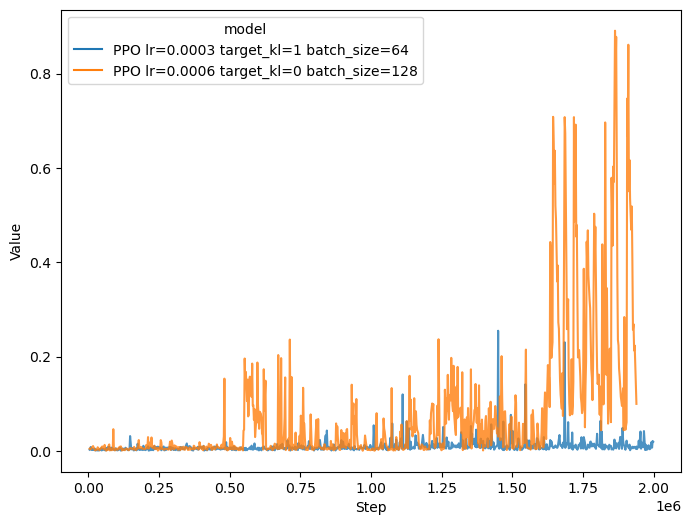

In [146]:
%matplotlib inline
plt.figure(figsize=(8, 6))
# plt.subplot(1, 2, 1)
ppo_df =  ppo_df[ (ppo_df['Value']<0.9) & (ppo_df['model']!='PPO lr=0.0005 target_kl=1 batch_size=128')]
sns.lineplot(data=ppo_df[ppo_df['Step']<=2000000], x="Step", y="Value",
             hue='model', alpha=0.8)
# .set_title("Approx KL Divergence")

In [ ]:
# clip fraction
ppo_df = pd.DataFrame(columns=['Wall time', 'Step', 'Value', 'model', 'Value_log'])

for i, p in zip(model_list, hp_list):
    path_ppo = f'{models_dir}/run-{i}-tag-train_clip_fraction.csv'

    ppo_df_tmp = pd.read_csv(path_ppo)
    ppo_df_tmp['model'] = p
    ppo_df_tmp['Value_log'] = np.log(ppo_df_tmp['Value'])
    ppo_df = pd.concat([ppo_df, ppo_df_tmp])

<AxesSubplot:xlabel='Step', ylabel='Value'>

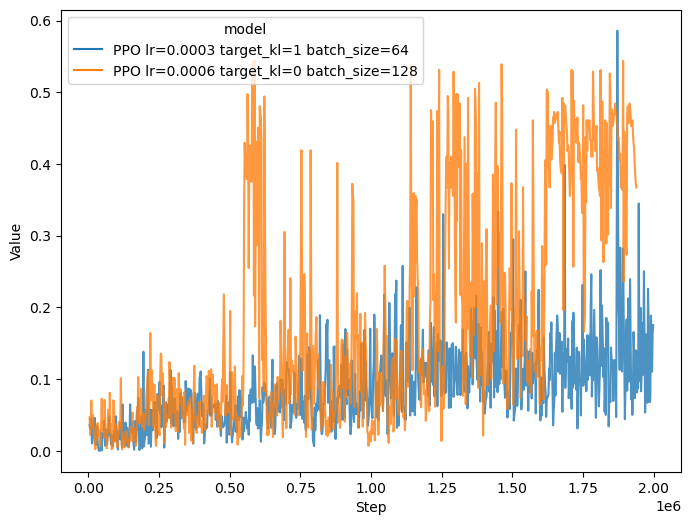

In [ ]:
%matplotlib inline
plt.figure(figsize=(8, 6))
# plt.subplot(1, 2, 1)
ppo_df = ppo_df[ (ppo_df['Value']<0.9) & (ppo_df['model']!='PPO lr=0.0005 target_kl=1 batch_size=128')]
sns.lineplot(data=ppo_df[ppo_df['Step']<=2000000], x="Step", y="Value",
             hue='model', alpha=0.8)
# .set_title("Clip Fraction")